In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import reduce
from matplotlib.lines import Line2D

In [2]:
fontsize = 16
lw = 2
cmap = 'viridis_r'
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='black', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)

In [15]:
path = '01_Data/02_Raw_Protein_Quan/DIANN180/'

names = ['indiv', 'mbr', 
         '+1_5', '+5_5', '+10_5', '+100_5',
         '+1_10', '+5_10', '+10_10', '+100_10',
         '+1_20', '+5_20', '+10_20', '+100_20']

quans = []

indiv_quans = []
for i in range(7):
    frame = pd.read_csv(path + 'r' + str(i+1) + '_pg_matrix_raw.csv')
    indiv_quans.append(frame)
    
quans.append(reduce(lambda left, right: pd.merge(left, right, on='Protein.Group', how='outer'), indiv_quans))

for name in names:
    if name != 'indiv':
        frame = pd.read_csv(path + name + '_pg_matrix_raw.csv')
        quans.append(frame)

dfs = [quans[0], quans[1], quans[8]] # individual, mbr & +10xME 10%Ecoli

merge = reduce(lambda left, right: pd.merge(left, right, on='Protein.Group', how='outer'), dfs)
merge.index = merge['Protein.Group']
merge.drop(columns='Protein.Group', inplace=True)

conditions = list(pd.unique([c.split('_')[0] for c in merge]))

In [16]:
merge.loc[:, ('Median')] = merge.median(axis=1)
merge_log = np.log2(merge).sort_values(by='Median', ascending=False)
merge_log_f = merge_log[~merge_log.index.str.contains(';')] 

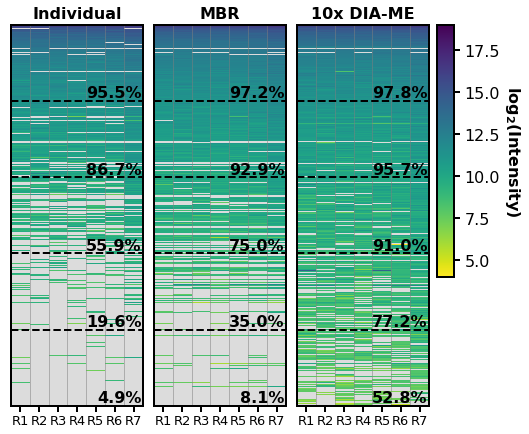

In [55]:
fig, ax = plt.subplots(1,3, figsize=(7.5,7), sharey=True)
plt.subplots_adjust(wspace=0.08)
cbar_ax = fig.add_axes([0.915,0.38,0.03,0.5])

xlabels = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
titles = ['Individual', 'MBR', '10x DIA-ME']
vmin, vmax = 4, 19
for i, cond in enumerate(conditions):
    
    data = merge_log_f[[c for c in merge_log_f.columns if cond in c]]
    sns.heatmap(data=data, xticklabels=xlabels, yticklabels=False, cmap=cmap, 
                vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, lw=0, ax=ax[i])

    ax[i].set_facecolor('gainsboro')
    
    ax[i].set_ylabel('')
    cbar_ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(Intensity)', rotation=270, fontsize=fontsize, fontweight='bold', labelpad=22)
    
    ax[i].set_title(titles[i], fontsize=fontsize, fontweight='bold', pad=7)
    
    ax[i].tick_params(axis='x', which='major', direction='out', pad=2, length=lw*3, width=lw, labelsize=fontsize-3)
    cbar_ax.tick_params(axis='y', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_visible(True)
        ax[i].spines[axis].set_linewidth(lw)
        cbar_ax.spines[axis].set_visible(True)
        cbar_ax.spines[axis].set_linewidth(lw)

    for j in range(6):
        ax[i].axvline(x=(j+1), linewidth=lw/4, color='grey')
        
    count = 0
    for j in range(5):

        index = count + round(len(data)/5)  # data devided in five sections
        box = data.iloc[count:index]
        count =+ index

        na_values = box.isna().sum().sum()
        values = box.notna().sum().sum()
        perc = (1 - na_values / (na_values + values)) *100
        
        ax[i].axhline(y=index, color='black', linestyle='dashed', linewidth=lw)
        ax[i].text(x=6.9, y=index-10, s=str(round(perc,1)) + '%', fontsize=fontsize, 
                   fontweight='bold', va='bottom', ha='right')
        
# plt.savefig('02_Figures/Protein_Ranked_Quantities_Heatmap.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Ranked_Quantities_Heatmap.pdf', dpi=400, bbox_inches='tight')

In [19]:
path2 = 'E:/KK/00_DKFZ/Protocols&Methods/09_Data Annotation/'
annos = [pd.read_csv(path2 + 'Cytoskeleton/human_associatedto_cytoskeleton.txt', sep='\t',
                       usecols=['UniProt_AccessionNumber', 'GeneName']),
         pd.read_csv(path2 + 'Cell Cycle/human_associatedto_cellcycle.txt', sep='\t',
                      usecols=['UniProt_AccessionNumber', 'GeneName'])]
anno_names = ['Cytoskeleton', 'Cell Cycle']

dfs = [quans[0], quans[1], quans[3], quans[4], quans[5]]
dfs_anno = []
for i, df in enumerate(dfs):
    
    dfs[i].index = df['Protein.Group']
    quan_cols = [c for c in df if 'R' in c]
    frame = np.log2(df[quan_cols])
    index = frame.index
    
    for j, anno in enumerate(annos):
        frame = frame.merge(anno, left_index=True, right_on='UniProt_AccessionNumber', how='left').set_index(index)
        frame = frame.drop(columns='UniProt_AccessionNumber').rename(columns={'GeneName': anno_names[j]})
    
    frame['Median'] = frame[quan_cols].median(axis=1)
    frame = frame.sort_values('Median', ascending=False)
    frame['Rank'] = range(1, len(frame) + 1) 
    dfs_anno.append(frame)  
    

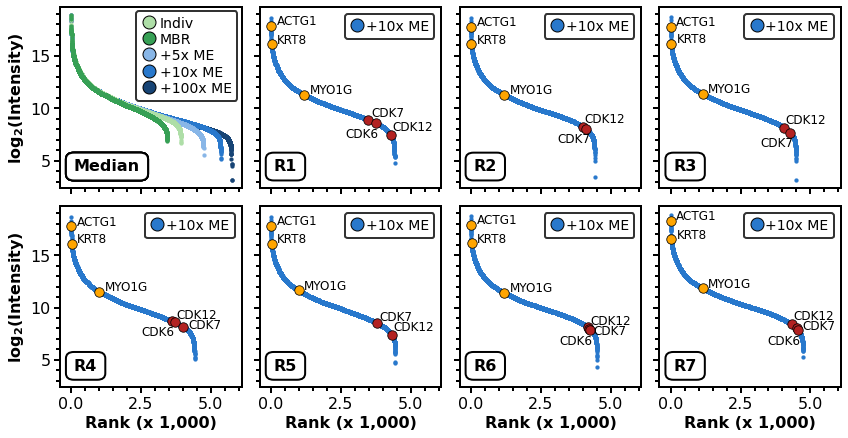

In [31]:
frame = dfs_anno[3]
quan_cols = [c for c in frame if '_R' in c]

sk_prots = ['P60709;P63261', 'P05787', 'B0I1T2'] 
sk_prot_labels = ['ACTG1', 'KRT8', 'MYO1G']
cc_prots = ['Q00534', 'P50613', 'Q9NYV4']  # CDK6, CDK7, CDK12
cc_prot_labels = ['CDK6', 'CDK7', 'CDK12']

greens = sns.color_palette('Greens', 2)
palette = [greens[0], greens[1], '#88B6E7', '#2878CC', '#174475']
size = 15

fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
axs = fig.axes

patches = []
labels = ['Indiv', 'MBR', '+5x ME', '+10x ME', '+100x ME']
count = 0
for i, df in enumerate(dfs_anno):
    if i == 1:
        zorder = 10
    else:
        zorder = 10 - count
    sns.scatterplot(data=df, x=df['Rank']/1000, y='Median', s=size, color=palette[i], 
                    edgecolor=None, zorder=zorder, ax=axs[0])
    count += 1
    axs[0].text(0.1, 4, 'Median', fontsize=fontsize, weight='bold', bbox=props)
    patches.append(Line2D([0],[0], lw=0, marker='o', color='k', label=labels[i],
                          markerfacecolor=palette[i], markersize=size-2, markeredgewidth=1))
legend = axs[0].legend(handles=patches, labelspacing=0.15, fontsize=fontsize-2, handlelength=1,
                       handleheight=1, handletextpad=0.3, edgecolor='k', loc=1, borderaxespad=0.3)
legend.get_frame().set_linewidth(2)
    
for i, col in enumerate(quan_cols):
    data = pd.DataFrame(frame[[col,'Cytoskeleton','Cell Cycle']]).sort_values(by=col, ascending=False).dropna(subset=col)
    data['Rank'] = range(1, len(data) + 1)
    sns.scatterplot(data=data, x=data['Rank']/1000, y=col, s=size, color=palette[3], 
                    edgecolor=None, ax=axs[i+1])
    axs[i+1].text(0.1, 4, 'R'+str(i+1), fontsize=fontsize, weight='bold', bbox=props)
    legend = axs[i+1].legend(handles=patches[3:4], fontsize=fontsize-2, handlelength=1, 
                             handleheight=1, handletextpad=0.1, edgecolor='k', loc=1)
    legend.get_frame().set_linewidth(2)
    
    for j, prot in enumerate(sk_prots):
        prot_data = pd.DataFrame(data.loc[prot]).T
        sns.scatterplot(prot_data, x=prot_data['Rank']/1000, y=col, s=size*6, color='orange', edgecolor='k', ax=axs[i+1])
        x = (prot_data['Rank']/1000)[0] + 0.2
        y = (prot_data[col])[0] + 0.1
        axs[i+1].text(x=x, y=y, s=sk_prot_labels[j], fontsize=fontsize-4)
    
    for prot in data.index:
        if cc_prots[0] == prot:
            prot_data = pd.DataFrame(data.loc[prot]).T
            sns.scatterplot(prot_data, x=prot_data['Rank']/1000, y=col, s=size*6, color='firebrick', edgecolor='k', ax=axs[i+1])
            x = (prot_data['Rank']/1000)[0] - 1.1
            y = (prot_data[col])[0] - 1.4
            axs[i+1].text(x=x, y=y, s=cc_prot_labels[0], fontsize=fontsize-4)
            
        if cc_prots[1] == prot:
            prot_data = pd.DataFrame(data.loc[prot]).T
            sns.scatterplot(prot_data, x=prot_data['Rank']/1000, y=col, s=size*6, color='firebrick', edgecolor='k', ax=axs[i+1])
            if i+1 == 2 or i+1 == 3:
                x = (prot_data['Rank']/1000)[0] - 1.05
                y = (prot_data[col])[0] - 1.3
            elif i+1 == 4 or i+1 == 7:
                x = (prot_data['Rank']/1000)[0] + 0.2
                y = (prot_data[col])[0] - 0.15
            elif i+1 == 6:
                x = (prot_data['Rank']/1000)[0] + 0.2
                y = (prot_data[col])[0] - 0.7
            else:   
                x = (prot_data['Rank']/1000)[0] + 0.1
                y = (prot_data[col])[0] + 0.25
            axs[i+1].text(x=x, y=y, s=cc_prot_labels[1], fontsize=fontsize-4)   
            
        if cc_prots[2] == prot:
            prot_data = pd.DataFrame(data.loc[prot]).T
            sns.scatterplot(prot_data, x=prot_data['Rank']/1000, y=col, s=size*6, color='firebrick', edgecolor='k', ax=axs[i+1])
            x = (prot_data['Rank']/1000)[0] + 0.05
            y = (prot_data[col])[0] + 0.4
            axs[i+1].text(x=x, y=y, s=cc_prot_labels[2], fontsize=fontsize-4)
            
        if 'Q14004;Q9NYV4' == prot:
            prot_data = pd.DataFrame(data.loc[prot]).T
            if i+1 == 5:
                sns.scatterplot(prot_data, x=prot_data['Rank']/1000, y=col, s=size*6, color='firebrick', edgecolor='k', ax=axs[i+1])
                x = (prot_data['Rank']/1000)[0] + 0.05
                y = (prot_data[col])[0] + 0.4
                axs[i+1].text(x=x, y=y, s='CDK12', fontsize=fontsize-4)
                
for ax in axs:
    
    ax.set_xlabel('Rank (x 1,000)', fontsize=fontsize, fontweight='bold')
    ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(Intensity)', fontsize=fontsize, fontweight='bold')
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', direction='out', length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)
    ax.set_xlim(-0.4, 6.1)
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)

# plt.savefig('02_Figures/Protein_Ranked_Quantities_Replicates.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Ranked_Quantities_Replicates.pdf', dpi=400, bbox_inches='tight')